In [20]:
import math
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import collections
from numpy import linalg
from collections import Counter
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import re
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings("ignore")
from IPython.display import clear_output

In [21]:
# from google.colab import drive
# drive.mount('/content/drive')
# folder_path = '/content/drive/My Drive/archive'
# os.chdir(folder_path)
# !ls

# Import data
df = pd.read_csv('articles1.csv')
#df2 = pd.read_csv('articles2.csv')
#df3 = pd.read_csv('articles3.csv')

# Merge data into one dataframe
#frames = [df1, df2, df3]
#data = pd.concat(frames)
#display(data.head())
# Convert data column into datetime
df['date'] = pd.to_datetime(df['date'])
columns_to_drop = ['Unnamed: 0', 'year', 'month', 'url']
df = df.drop(columns=columns_to_drop)
df = df.head(500)

In [22]:
# Download NLTK resources
nltk.download('stopwords')

# Function to preprocess content column
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, digits and white space using regex expression
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    # Apply stemming using NLTK PorterStemmer
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_words)

def preprocess_text_lower(text):
    # Converts to lowercase, removes symbols and stopword, but does not stem
    text = text.lower()
    # Remove special characters, digits and white space using regex expression
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the 'content' column
df['preprocessed_content'] = df['content'].apply(preprocess_text)
df['content_lowercase'] = df['content'].apply(preprocess_text_lower)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Create vocabulary
def vocabulary(docs):
  vocab = set()
  for doc in docs:
    for word in doc:
        vocab.add(word)
  return sorted(vocab)

# Term frequency
def term_frequency(documents, vocabulary):
  # Count word occurences for each document
  tf_matrix = pd.DataFrame(0, index=np.arange(len(documents)), columns=vocabulary)
  for i, document in enumerate(documents):
    for word in document:
        tf_matrix.at[i, word] += 1
  return tf_matrix

# Inverse Document Frequency
def inverse_document_frequency(documents, vocabulary):
  # We want to reduce the weight of terms that appear frequently in our collection of articles.
  idf = pd.Series(0, index=vocabulary)
  for word in vocabulary:
    counter = 0
    for document in documents:
      if word in document:
          counter += 1
    idf[word] = np.log((1+len(documents))/(counter+1))+1 # df(t)=log[(1 + n)/(1+df(t))]+1, like using smooth_idf=True in Sklearn library to prevents zero divisions
  return idf

# TF-IDF
def tf_idf(tf_matrix, idf, documents):
  tfidf_matrix = tf_matrix.copy()
  for i in range(len(documents)):
    tfidf_matrix.iloc[i] = tf_matrix.iloc[i] * idf
  tfidf_matrix = normalize(tfidf_matrix, norm='l2', axis=1) # L2 normalization to scale vectors
  tfidf_matrix = pd.DataFrame(tfidf_matrix, columns=vocab)
  return tfidf_matrix

In [24]:
# Extract documents
docs = df['preprocessed_content'].str.split()
# Vocabulary
vocab = vocabulary(docs)
# TF
tf_matrix = term_frequency(docs, vocab)
# IDF
idf = inverse_document_frequency(docs, vocab)
# TF-IDF
tfidf_matrix = tf_idf(tf_matrix, idf, docs)

In [25]:
tfidf_matrix

,aaa,aaron,aback,abad,abadi,abandon,abat,abba,abbey,abbrevi,...,zoom,zoomin,zootopia,zoraida,zsa,zsolt,zubaydah,zuckerberg,zuhair,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030652,0.0,0.0,...,0.0,0.0,0.0,0.0,0.069136,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [26]:
tfidf_matrix.shape

(500, 18437)

In [27]:
# corpus = df['preprocessed_content'].tolist()
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(corpus)
# # word_list = []
# # for item in vectorizer.get_feature_names_out():
#     # print(item)
#     # word_list.append(item)

# X = X.toarray()
# tfidf_matrix = pd.DataFrame(X)

# tfidf_matrix.head()

# print(len(word_list))
# print(X.shape)

# tfidf_matrix = pd.DataFrame(X, columns=word_list) 
# print(X[0,2])
# tfidf_matrix.shape

# for i in range(X.shape[0]):
    # for j in range(X.shape[1]):
        # print(X[i])



# print(X1.shape)

# print(type(X1))

# # Create a NumPy array
# X = np.array([[7, 8, 9], [4, 5, 6]])

# print(X.shape)

# np_df = pd.DataFrame(X)

# # np_df.info()
 
# # Convert NumPy array to list using a loop
# list_from_numpy = []
# for item in X:
#     for subitem in item:
#         list_from_numpy.append(subitem)
 
# print(list_from_numpy)

In [28]:
# tfidf_matrix

In [29]:
class KMeansAlgorithm:

    def __init__(self, X, k, max_iterations=100):
      self.X = X.values
      self.k = k
      self.max_iterations = max_iterations
      self.centroids = None
      self.num_articles, num_features = X.shape

    def init_random_centroids(self):
      idx = np.random.choice(self.num_articles, size=self.k, replace=False)
      centroids = self.X[idx]
      return centroids

    def calculate_euclidean_distances(self):
      num_centroids = self.centroids.shape[0]
      distances = np.zeros((num_centroids, self.num_articles))

      for centroid_idx in range(num_centroids):
          for article_idx in range(self.num_articles):
              distances[centroid_idx, article_idx] = np.sqrt(np.sum((self.centroids[centroid_idx, :] - self.X[article_idx, :]) ** 2))
      return distances

    def update_centroids(self, labels):
        new_centroids = []
        for k in range(self.k):
            mean = self.X[labels == k].mean(axis=0)
            new_centroids.append(mean)
        new_centroids = np.array(new_centroids)
        return new_centroids

    def plot_clusters(self, labels, centroids, iteration):
        from matplotlib import cm
        unique_labels = np.unique(labels)
        pca = PCA(n_components=3)
        data_3d = pca.fit_transform(self.X)
        centroids_3d = pca.transform(centroids)
        # 3D plot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        color_map = cm.get_cmap('turbo', len(unique_labels))
        # Plot data
        for label in unique_labels:
            indices = labels == label # like [1, 2, 1, 3, 1]
            ax.scatter(data_3d[indices, 0], data_3d[indices, 1], data_3d[indices, 2], label=f'Cluster {label}', c=[color_map(label)])
        # Plot centroids
        ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], c='red', marker='x', s=80, label='Centroids')
        ax.set_title(f'PCA 3D - iteration {iteration}')
        ax.set_xlabel('Principal component 1')
        ax.set_ylabel('Principal component 2')
        ax.set_zlabel('Principal component 3')
        ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
        clear_output(wait=True)
        plt.show()

    def fit(self):

      self.centroids = self.init_random_centroids()

      for i in range(self.max_iterations):
        distances = self.calculate_euclidean_distances()
        labels = np.argmin(distances, axis=0)
        new_centroids = self.update_centroids(labels)

        if np.all(new_centroids == self.centroids):
          print("Kmeans has converged!")
          break

        self.centroids = new_centroids

        self.plot_clusters(labels, self.centroids, i)

      return labels

In [30]:
# We will use elbow method to find optimal number of clusters
# num_clusters = range(1, 30)
# wcss = []

# for k in num_clusters:
#     # We will use Sklearn's Kmeans algorithm, but use random intialization as used in our implementation
#     kmeans = KMeans(n_clusters=k, random_state=123)
#     kmeans.fit(tfidf_matrix)
#     wcss.append(kmeans.inertia_)

# # Plot the Elbow Method
# plt.plot(num_clusters, wcss, marker='o')
# plt.title('Elbow Method - KMeans with random initialization')
# plt.xlabel('Number of clusters')
# plt.ylabel('Wcss')
# plt.show()

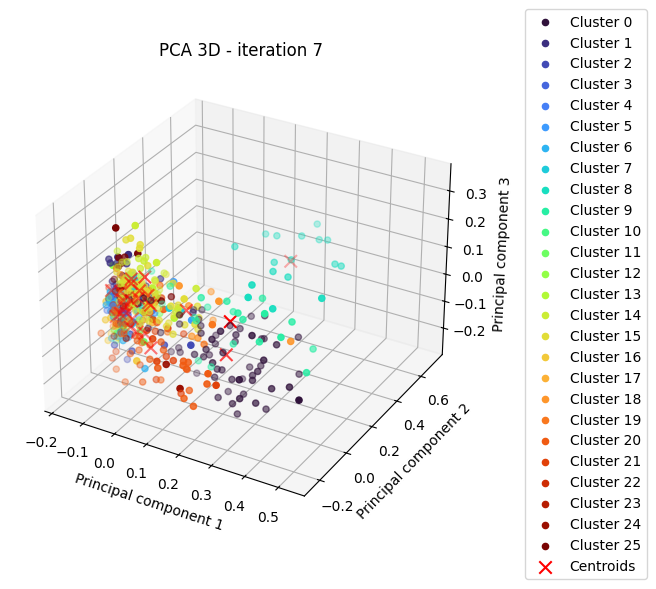

Kmeans has converged!


In [31]:
Kmeans = KMeansAlgorithm(tfidf_matrix, 26)
labels = Kmeans.fit()

In [32]:
display(labels)

array([ 8, 13,  6, 19, 15, 13,  7,  4,  6, 10,  0, 15,  0,  2,  3,  6, 13,
       15, 25,  6,  6, 11, 12,  2,  8,  8, 15, 14, 25, 14, 24, 15, 24, 18,
        1, 15, 11,  6, 11,  8, 15,  8,  0,  9,  0, 13,  4, 15, 20,  6, 11,
       15,  7, 25, 21,  6, 10,  8,  8,  8,  0,  0, 13, 25, 14,  6, 23, 16,
        6, 16, 15,  9, 21,  7, 15,  5,  1,  0, 23, 11, 15,  3, 16,  7,  6,
       21,  3,  9, 18,  9, 15,  8,  0,  0, 21, 15, 15,  1, 15, 15, 24,  6,
       13, 15, 16, 13,  3, 15,  6,  9,  9, 14, 14,  0,  0,  0, 15, 19, 15,
       15, 25,  4, 20, 20, 15, 11,  0,  3,  1, 15,  3,  3, 11,  3, 11,  9,
       18, 25, 15,  0,  4, 21, 11, 21, 21, 19, 14,  6, 14,  2, 25, 21, 15,
       11, 14, 20,  9, 15,  9,  9, 25, 14, 13, 20, 20, 20, 24, 20,  2,  6,
        0,  0, 15, 15, 15, 25, 16, 15, 15, 16,  6, 16, 21, 15, 13,  3, 16,
        6,  0,  8, 21, 11,  1, 14, 15, 14,  6,  1, 15, 20, 20, 20, 12, 12,
       17, 15, 15, 20,  0,  0,  0,  0, 13, 14, 20, 13, 18,  6,  1,  4,  0,
        0, 15,  9,  0,  0

In [33]:
# Create dataframe with cluster numbers as columns
clustered_df = pd.DataFrame()

list_to_append = [] # Row of null values that can be appended to dataframe

for i in range(len(np.unique(labels))):
    clustered_df[str(i)] = ''
    list_to_append.append(np.nan)

# print(list_to_append)
for i in range(len(labels)):
    # Initialize row with null values
    clustered_df.loc[len(clustered_df.index)] = list_to_append
    # If article belongs to cluster append it to dataframe
    clustered_df.loc[i,str(labels[i])] = df.loc[i,'content_lowercase']

clustered_df.shape

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WASHINGTON — Congressional Republicans have...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"Death may be the great equalizer, but it isn’t...",NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
clustered_df.head()

In [34]:
# This DataFrame has only one row, and the same number of columns as there are clusters.
# Every column contains ALL the text of a given cluster.
text_cluster_df = pd.DataFrame()

list_to_append = [] # Row of null values that can be appended to dataframe

for i in range(clustered_df.shape[1]):
    text_cluster_df[str(i)] = ''
    list_to_append.append(np.nan)

# Initialize first row
text_cluster_df.loc[len(text_cluster_df.index)] = list_to_append

# text_cluster_df.head()

text = []

for i in range(clustered_df.shape[1]):
    for j in range(clustered_df.shape[0]):
        if (pd.notnull(clustered_df.loc[j,str(i)])):
            text.append(clustered_df.loc[j,str(i)])
    text_cluster_df.loc[0, str(i)] =  ' '.join(text)
    text = []

text_cluster_df.shape

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,With Donald J. Trump about to take control of ...,RIO DE JANEIRO — A prison riot involving ga...,This article is part of a series aimed at help...,It’s the season for family travel and photos ...,"Danny Cahill stood, slightly dazed, in a blizz...","Rajiv J. Shah, a trustee of the Rockefeller Fo...","When Walt Disney’s “Bambi” opened in 1942, cri...",BEIJING — President Tsai of Taiwan sharpl...,WASHINGTON — Congressional Republicans have...,■ Donald J. Trump appears to side with the W...,...,"Whether the music to your ears is pop, classic...",Greetings Earthlings! This is your planet and ...,OTTAWA — It was 7 a. m. and 99 passengers a...,"Death may be the great equalizer, but it isn’t...","For Megyn Kelly, the shift from Fox News to NB...",Our new president is a billionaire Ivy Leag...,"Every Friday, we’ll offer a Trilobite talking...","For the 12th straight year, the Travel section...",With the year winding down and New Year’s reso...,BAGHDAD — A suicide bomber detonated a pick...


In [ ]:
text_cluster_df.head()

In [35]:
text_cluster_df.loc[0,'0']

'With Donald J. Trump about to take control of the White House, it would seem a dark time for the renewable energy industry. After all, Mr. Trump has mocked the science of global warming as a Chinese hoax, threatened to kill a global deal on climate change and promised to restore the coal industry to its former glory. So consider what happened in the middle of December, after investors had had a month to absorb the implications of Mr. Trump’s victory. The federal government opened bidding on a tract of the ocean floor off New York State as a potential site for a huge wind farm. Up, up and away soared the offers  —   interest from the bidders was so fevered that the auction went through 33 rounds and spilled over to a second day. In the end, the winning bidder offered the federal Treasury $42 million, more than twice what the government got in August for oil leases  —   oil leases  —   in the Gulf of Mexico. Who won the bid? None other than Statoil, the Norwegian oil company, which is i

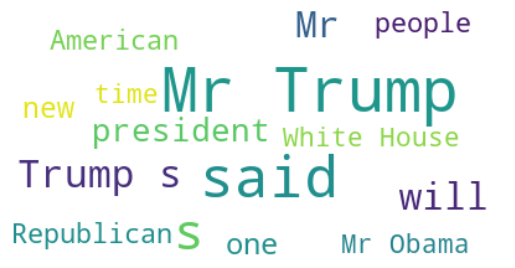

In [36]:
# # WORDCLOUD

# text = text_cluster_df.loc[0,'0']

# # Create and generate a word cloud image:
# wordcloud = WordCloud().generate(text)

# # Display the generated image:
# # plt.imshow(wordcloud, interpolation='bilinear')
# # plt.axis("off")
# # plt.show()

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=15, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

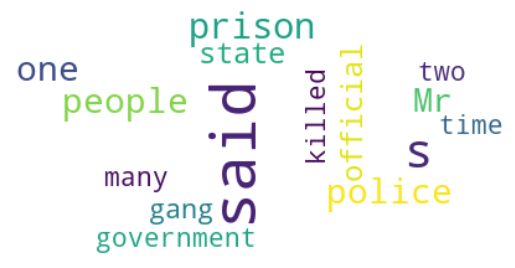

In [37]:
# # WORDCLOUD

# text = text_cluster_df.loc[0,'1']

# # Create and generate a word cloud image:
# wordcloud = WordCloud().generate(text)

# # Display the generated image:
# # plt.imshow(wordcloud, interpolation='bilinear')
# # plt.axis("off")
# # plt.show()

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=15, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

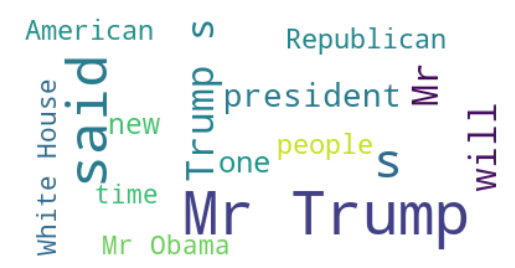

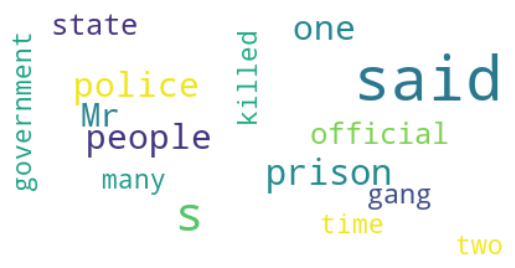

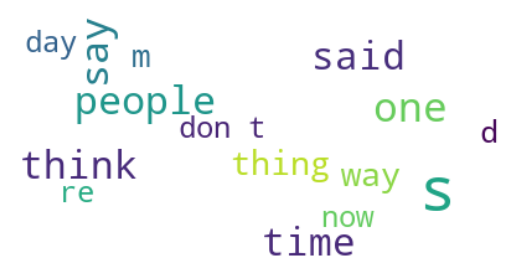

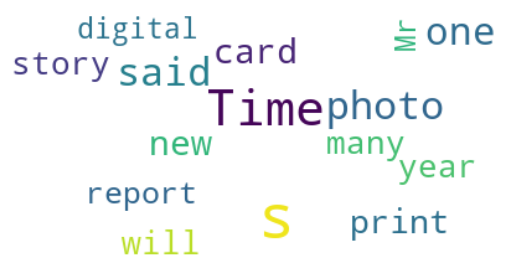

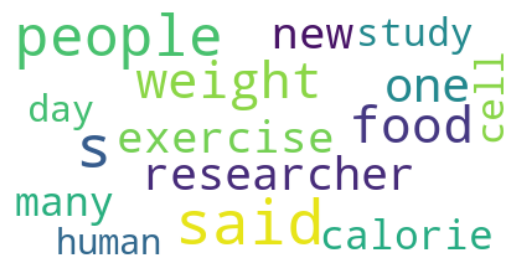

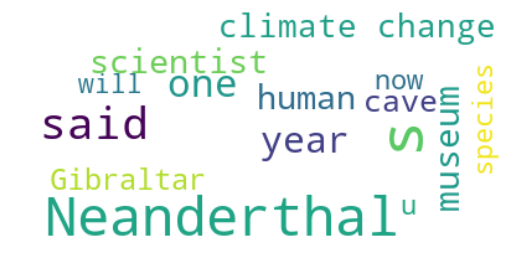

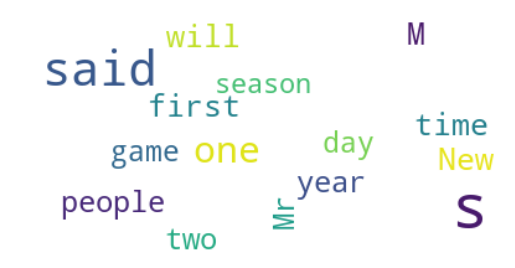

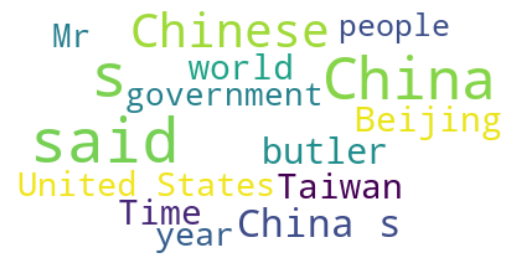

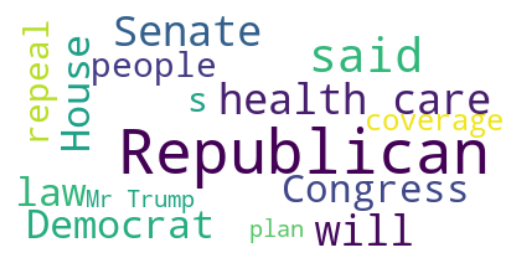

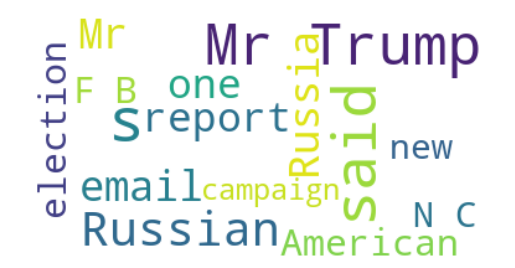

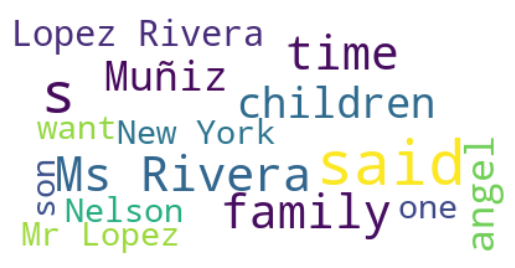

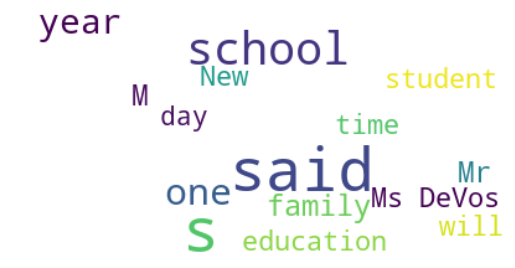

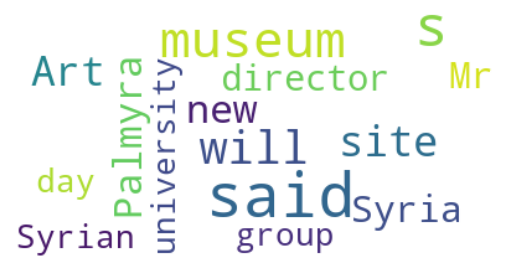

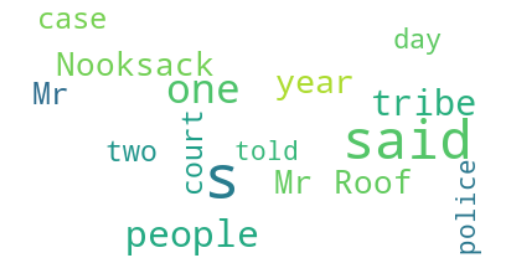

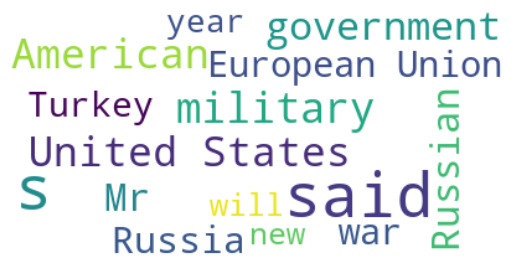

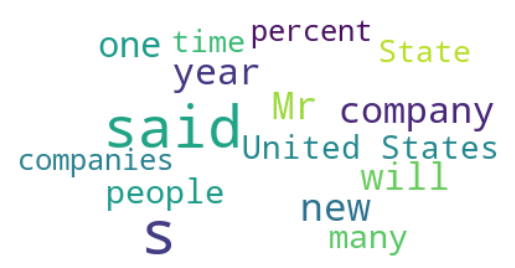

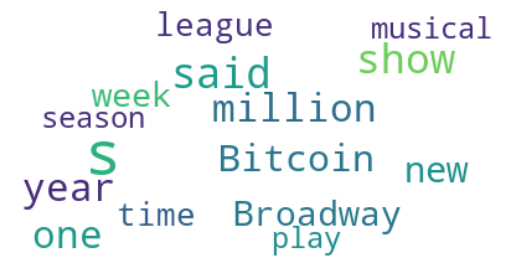

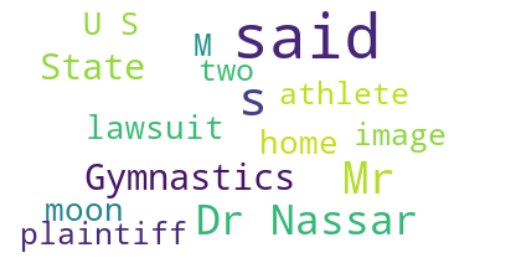

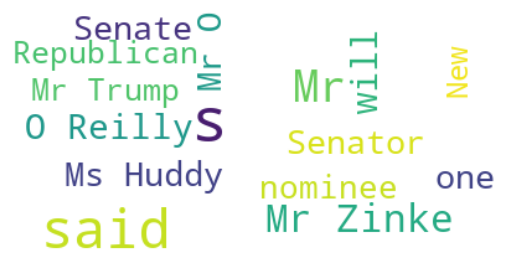

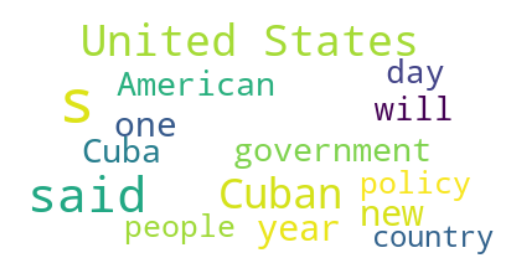

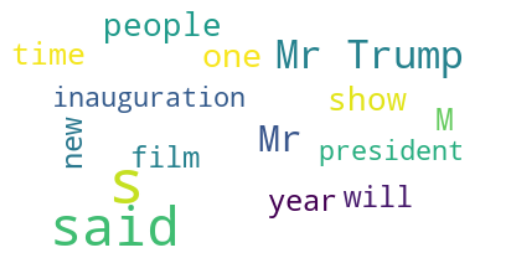

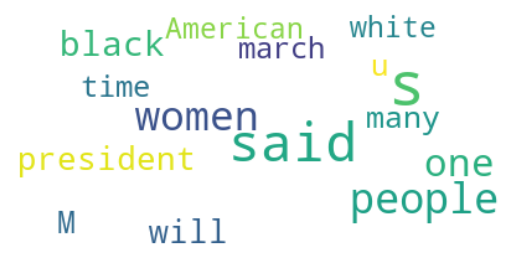

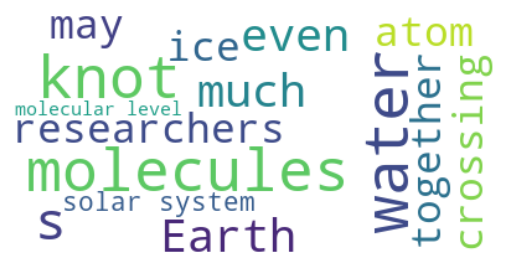

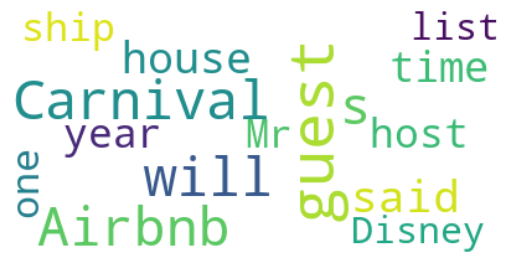

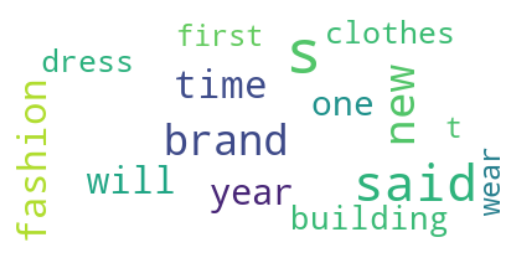

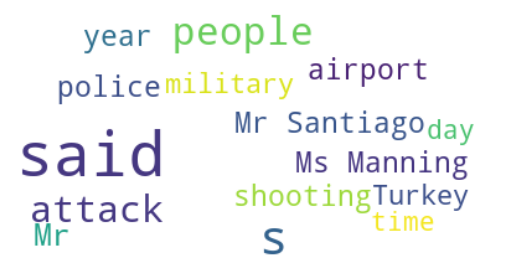

In [38]:
# WORDCLOUD
wordclouds = []
for i in range(text_cluster_df.shape[1]):

    text = text_cluster_df.loc[0,str(i)]

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # plt.imshow(wordcloud, interpolation='bilinear')
    # plt.axis("off")
    # plt.show()

    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=15, background_color="white").generate(text)
    wordclouds.append(wordcloud)
    # plt.figure()
    # plt.imshow(wordcloud, interpolation="bilinear")
    # plt.axis("off")
    # plt.show()

In [ ]:
plt.figure()
plt.imshow(wordclouds[2], interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
plt.figure(figsize=(17, 17))
# plt.subplots_adjust(hspace=0.1)
# plt.suptitle("Wordclouds", fontsize=18, y=0.95)
for n, cloud in enumerate(wordclouds):
    # add a new subplot iteratively
    ax = plt.subplot(7, 4, n + 1)
    ax.imshow(cloud, interpolation="bilinear")
    ax.set_xlabel(str(n+1), fontsize=18)
    plt.xticks([])
    plt.yticks([])

plt.savefig('wordclouds-nolib.png', bbox_inches='tight', pad_inches=0.25)